# Spatial correlation

$$r = \frac{\sum[(F^\text{true} - \langle F^\text{true}\rangle) (F^\text{param} - \langle F^\text{param}\rangle)]}{\sqrt{\sum[(F^\text{true} - \langle F^\text{true}\rangle)^2]}\sqrt{\sum[(F^\text{param} - \langle F^\text{param}\rangle)^2]}}$$

In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:46814")
client

Client Scheduler: tcp://127.0.0.1:46814 Dashboard: http://127.0.0.1:36808/status,Cluster Workers: 8 Cores: 40 Memory: 169.33 GB


In [2]:
import numpy as np
import xarray as xr
import gsw
import time
from xmitgcm import open_mdsdataset
from xgcm.grid import Grid
from MITgcmutils import jmd95
from dask.diagnostics import ProgressBar
import os.path as op
from scipy.interpolate import griddata
from scipy.stats import pearsonr
import dask_image.ndfilters as dsfilt
import scipy.sparse as spar
import dask.array as dsar
from xhistogram.xarray import histogram as xhist
import xrft
import xscale
import matplotlib.pyplot as plt
import matplotlib.colors as clr
from matplotlib.lines import Line2D
%matplotlib inline

In [3]:
rdir = '/tank/chaocean/'
ddir = '/tank/topog/tuchida/TWA/'

In [4]:
dnf = 2160

grav = 9.81
Kh = 20.
K4 = 1e10
Kr = 1e-5
thetaMax = 1e20
rhoConst = 9.998e2
Cp = 3.994e3
ySstart = -15
yNstart = 10
yend = 50
sstart = 13
send = 34
nremap = 50
dnf = 2160
nchk = 20
nhskp = 3
nbskp = 2
nremap = 80

mchunk = 1
xchunk = 250
ychunk = 400
schunk = -1

In [5]:
# ny, nx, nb = (3,3,1)
# def _filt(da, nker=np.ones((ny,nx,nb))):
#     return xr.DataArray(dsfilt.median_filter(da.data, footprint=nker), 
#                         dims=da.dims, coords=da.coords)
def _filt(da, area=None, dim=['YC','XC'], nker=5, cutoff=3):
    
    if area is not None:
        win_2D = (da * area).window
    else:
        win_2D = da.window
    
    win_2D.set(window='hanning', cutoff=cutoff, dim=dim, n=[nker,nker])
    bw = win_2D.boundary_weights(drop_dims=[])
    da_LS = win_2D.convolve(weights=bw)
    
    if area is not None:
        area_win = area.window
        area_win.set(window='hanning', cutoff=cutoff, dim=dim, n=[nker,nker])
        bw = area_win.boundary_weights(drop_dims=[])
        da_LS *= area_win.convolve(weights=bw)**-1
    
    return da_LS

#########################
def _dot(self, other):
    func = np.dot(self[0,0,0], other[0,0,0])
    return np.expand_dims(func, (0,1,2))

Lapse time: 74.63994526863098
1261440
Lapse time: 77.72252917289734
1263600
Lapse time: 79.52263021469116
1265760
Lapse time: 76.20597290992737
1267920
Lapse time: 76.10710716247559
1270080
Lapse time: 77.90724849700928
1272240
Lapse time: 75.60110187530518
1274400
Lapse time: 77.78947067260742
1276560
Lapse time: 84.03071665763855
1278720
Lapse time: 219.6338984966278
1280880
Lapse time: 244.76781845092773
1283040
Lapse time: 261.7636344432831
1285200
Lapse time: 257.9986832141876
1287360
Lapse time: 243.46481084823608
1289520
Lapse time: 255.4000985622406
1291680
Lapse time: 273.3946490287781
1293840
$r^x_\Pi$: 0.9366244559784119 $r^y_\Pi$: 0.9047590590024885
$r^x_\theta$: 0.9741092639608776 $r^y_\theta$: 0.9599459402568803


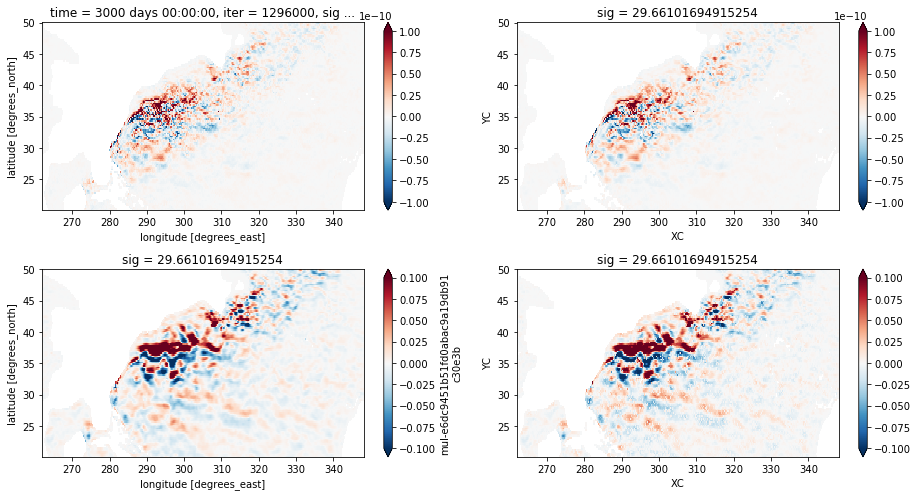

Lapse time: 332.1288104057312
1296000
Lapse time: 290.37880063056946
1298160
Lapse time: 526.734854221344
1300320
Lapse time: 403.84805369377136
1302480
Lapse time: 130.30848050117493
1304640
Lapse time: 132.75089383125305
1306800
Lapse time: 131.92870783805847
1308960
Lapse time: 175.68498826026917
1311120
Lapse time: 177.94376516342163
1313280
Lapse time: 178.4336907863617
1315440
Lapse time: 181.22265195846558
1317600
Lapse time: 191.68696975708008
1319760
Lapse time: 201.3752601146698
1321920
Lapse time: 199.1953809261322
1324080
Lapse time: 201.27800583839417
1326240
Lapse time: 197.48090386390686
1328400
Lapse time: 205.8542037010193
1330560
Lapse time: 208.48652148246765
1332720
Lapse time: 230.9270842075348
1334880
Lapse time: 232.72156810760498
1337040
<xarray.Dataset>
Dimensions:  (XC: 334, YC: 120, sig: 11)
Coordinates:
    time     timedelta64[ns] ...
    iter     int64 ...
  * YC       (YC) float64 20.17 20.42 20.67 20.92 ... 49.17 49.42 49.67 49.92
  * XC       (XC) float

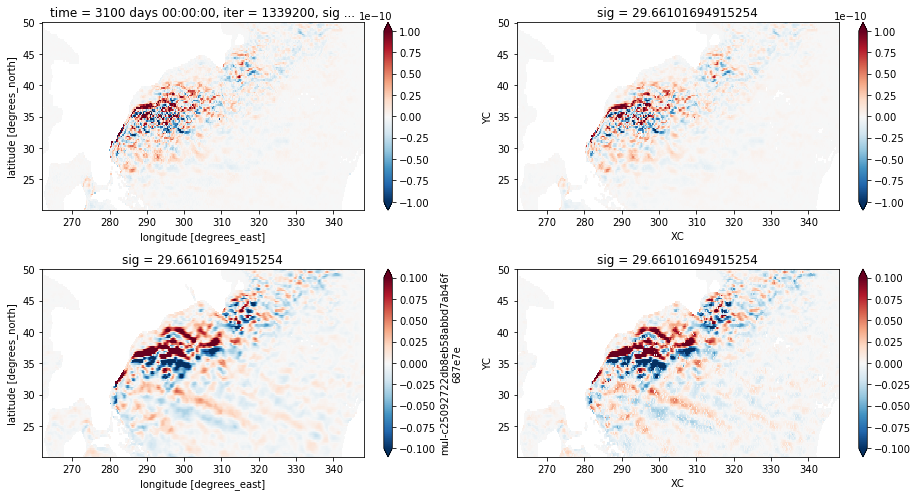

Lapse time: 334.4858524799347
1339200
Lapse time: 247.22178316116333
1341360
Lapse time: 288.3777484893799
1343520
Lapse time: 287.9225845336914
1345680
Lapse time: 306.6426913738251
1347840
Lapse time: 283.6041669845581
1350000
Lapse time: 304.4264841079712
1352160
Lapse time: 318.4588031768799
1354320
Lapse time: 231.2654411792755
1356480
Lapse time: 164.44388008117676
1358640
Lapse time: 172.90297746658325
1360800
Lapse time: 182.23879289627075
1362960
Lapse time: 174.6320140361786
1365120
Lapse time: 200.46472668647766
1367280
Lapse time: 187.0468578338623
1369440
Lapse time: 191.25940918922424
1371600
Lapse time: 190.3525538444519
1373760
Lapse time: 208.9933307170868
1375920
Lapse time: 192.95237159729004
1378080
Lapse time: 209.97391319274902
1380240
<xarray.Dataset>
Dimensions:  (XC: 334, YC: 120, sig: 11)
Coordinates:
    time     timedelta64[ns] ...
    iter     int64 ...
  * YC       (YC) float64 20.17 20.42 20.67 20.92 ... 49.17 49.42 49.67 49.92
  * XC       (XC) float32 2

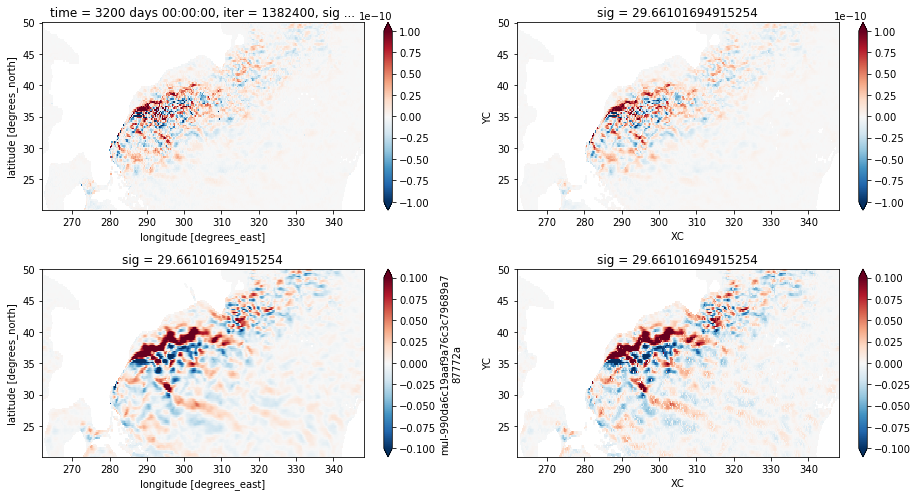

Lapse time: 278.8720269203186
1382400
Lapse time: 230.48803806304932
1384560
Lapse time: 246.03822469711304
1386720
Lapse time: 225.20088815689087
1388880
Lapse time: 268.4027531147003
1391040
Lapse time: 255.865478515625
1393200
Lapse time: 271.39944314956665
1395360
Lapse time: 273.5700261592865
1397520
Lapse time: 283.7369291782379
1399680
Lapse time: 287.20610070228577
1401840
Lapse time: 287.10231947898865
1404000
Lapse time: 293.39570665359497
1406160
Lapse time: 319.01211762428284
1408320
Lapse time: 309.0345332622528
1410480
Lapse time: 271.09153032302856
1412640
Lapse time: 286.0039372444153
1414800
Lapse time: 270.015572309494
1416960


In [6]:
year = 1966

# ntimes = np.arange( 943920+dnf,1101600+dnf,dnf,dtype=int)
# ntimes = np.arange(1101600+dnf,1259280+dnf,dnf,dtype=int)
ntimes = np.arange(1259280+dnf,1416960+dnf,dnf,dtype=int)
# ntimes = np.arange(1416960+dnf,1574640+dnf,dnf,dtype=int)
for itime in ntimes:
    K = xr.open_dataset(op.join(ddir,
                                '%4d/Diff-tensor_isig13-33_nskip3_%010d_Hann_no-smoothness.nc' 
                                % (year,itime))).K  
    ds = open_mdsdataset(op.join(rdir,'qjamet/RUNS/ORAR/memb%02d/run%4d/ocn/' 
                                  % (24,year)), 
                         grid_dir=op.join(rdir,'grid_chaO/gridMIT_update1/'),
                         iters=itime,
                         prefix=['diag_ocnSnap'], delta_t=2e2,
                        ).sel(YC=slice(yNstart+10-12**-1,yend+2*12**-1), 
                              YG=slice(yNstart+10-12**-1,yend+2*12**-1)
                             ).chunk({'XC':xchunk,'XG':xchunk,
                                      'YC':ychunk,'YG':ychunk})
    dsz = xr.open_dataset(op.join(ddir,'%4d/Zs_membs_parallel-%2d_%010d.nc' 
                                  % (year,nremap,itime)),
                          chunks={'nmemb':1}
                         ).isel(sig=slice(sstart,send),
                                sigp1=slice(sstart,send+1)
                               ).sel(YC=slice(yNstart+10-12**-1,yend+2*12**-1),
                                     YG=slice(yNstart+10-12**-1,yend+2*12**-1))
    dsmn = xr.open_dataset(op.join(ddir,'%4d/Dyn_membs_parallel-%2d_%010d.nc' 
                                   % (year,nremap,itime)),
                           chunks={'nmemb':1}
                          ).isel(sig=slice(sstart,send),
                                 sigp1=slice(sstart,send+1)
                                ).sel(YC=slice(yNstart+10-12**-1,yend+2*12**-1),
                                      YG=slice(yNstart+10-12**-1,yend+2*12**-1))
    dsdiv = xr.open_dataset(op.join(ddir,'%4d/divE-P_flux_parallel-%2d_%010d.nc' 
                                    % (year,nremap,itime)),
                           ).isel(sig=slice(sstart,send),
                                  sigp1=slice(sstart,send+1)
                                 ).sel(YC=slice(yNstart+10-12**-1,yend+2*12**-1),
                                       YG=slice(yNstart+10-12**-1,yend+2*12**-1))
#     dsmn = xr.open_zarr(op.join(ddir,'%4d/Dyns/%7d' % (year,itime))
#                        ).isel(sig=slice(sstart,send),
#                               sigp1=slice(sstart,send+1)
#                              ).sel(YC=slice(yNstart+10-12**-1,yend+2*12**-1),
#                                    YG=slice(yNstart+10-12**-1,yend+2*12**-1))
#     dsz = xr.open_zarr(op.join(ddir,'%4d/Zs/%7d' % (year,itime))
#                       ).isel(sig=slice(sstart,send),
#                              sigp1=slice(sstart,send+1)
#                             ).sel(YC=slice(yNstart+10-12**-1,yend+2*12**-1),
#                                   YG=slice(yNstart+10-12**-1,yend+2*12**-1))
#     dsdiv = xr.open_zarr(op.join(ddir,'%4d/E-P/%7d' % (year,itime))
#                         ).isel(sig=slice(sstart,send),
#                                sigp1=slice(sstart,send+1)
#                               ).sel(YC=slice(yNstart+10-12**-1,yend+2*12**-1),
#                                     YG=slice(yNstart+10-12**-1,yend+2*12**-1))
    
    if itime == ntimes[0]:
        grid = Grid(dsz, periodic=['X'], 
                    coords={'Z':{'center':'sig','outer':'sigp1'},
                           'Y':{'center':'YC','left':'YG'},
                           'X':{'center':'XC','left':'XG'}}
                   )
    buoybp1 = -grav * dsz.sigp1 * rhoConst**-1
    sigma = dsz.dzetaF * -grid.diff(buoybp1,'Z',boundary='fill')**-1
    sigmay = dsz.dzetaFy * -grid.diff(buoybp1,'Z',boundary='fill')**-1
    sigmax = dsz.dzetaFx * -grid.diff(buoybp1,'Z',boundary='fill')**-1

    sigmab = (dsz.dzetaF.mean('nmemb',skipna=True) 
              * -grid.diff(buoybp1,'Z',boundary='fill')**-1
             )
    sigmaxb = (dsz.dzetaFx.mean('nmemb',skipna=True) 
               * -grid.diff(buoybp1,'Z',boundary='fill')**-1
              )
    sigmayb = (dsz.dzetaFy.mean('nmemb',skipna=True) 
               * -grid.diff(buoybp1,'Z',boundary='fill')**-1
              )
        
##########################
    vhat = dsmn.vdz.mean('nmemb',skipna=True) * dsz.dzetaFy.mean('nmemb',skipna=True)**-1
    uhat = dsmn.udz.mean('nmemb',skipna=True) * dsz.dzetaFx.mean('nmemb',skipna=True)**-1
    vort = (grid.diff(vhat*ds.dyC,'X') 
            - grid.diff(uhat*ds.dxC,'Y',boundary='fill')
           ) * ds.rAz**-1
    fC = xr.apply_ufunc(gsw.f, dsz.YC)
    Pi = (fC + grid.interp(grid.interp(vort,'Y',boundary='fill'),
                           'X')
         ) * sigmab**-1
    Pi_sm = _filt(Pi.chunk({'YC':ychunk,'XC':xchunk}))
    Pism_x = grid.interp(grid.diff(Pi_sm,'X') * ds.dxC**-1,'X')
    Pism_y = grid.interp(grid.diff(Pi_sm,'Y',boundary='fill') * ds.dyC**-1,
                         'Y',boundary='fill')
    FxP = -(K[:,:,:,0,0] * Pism_x
            + K[:,:,:,1,0] * Pism_y
           ).sel(YC=slice(yNstart+10,yend+12**-1))
    FyP = -(K[:,:,:,0,1] * Pism_x
            + K[:,:,:,1,1] * Pism_y
           ).sel(YC=slice(yNstart+10,yend+12**-1))
####
    that = dsmn.tdz.mean('nmemb',skipna=True) * dsz.dzetaF.mean('nmemb',skipna=True)**-1
    shat = dsmn.sdz.mean('nmemb',skipna=True) * dsz.dzetaF.mean('nmemb',skipna=True)**-1
    that_sm = _filt(that)
    shat_sm = _filt(shat)
    thatsm_x = grid.interp(grid.diff(that_sm,'X') * ds.dxC**-1,'X')
    thatsm_y = grid.interp(grid.diff(that_sm,'Y',boundary='fill') * ds.dyC**-1,
                           'Y',boundary='fill')
    shatsm_x = grid.interp(grid.diff(shat_sm,'X') * ds.dxC**-1,'X')
    shatsm_y = grid.interp(grid.diff(shat_sm,'Y',boundary='fill') * ds.dyC**-1,
                           'Y',boundary='fill')
    FxT = -(K[:,:,:,0,0] * thatsm_x
            + K[:,:,:,1,0] * thatsm_y
           ).sel(YC=slice(yNstart+10,yend+12**-1))
    FyT = -(K[:,:,:,0,1] * thatsm_x
            + K[:,:,:,1,1] * thatsm_y
           ).sel(YC=slice(yNstart+10,yend+12**-1))
    FxS = -(K[:,:,:,0,0] * shatsm_x
            + K[:,:,:,1,0] * shatsm_y
           ).sel(YC=slice(yNstart+10,yend+12**-1))
    FyS = -(K[:,:,:,0,1] * shatsm_x
            + K[:,:,:,1,1] * shatsm_y
           ).sel(YC=slice(yNstart+10,yend+12**-1))

##########################
    Eu = dsdiv.e00x + dsdiv.e10y + dsdiv.e20b
    Ev = dsdiv.e01x + dsdiv.e11y + dsdiv.e21b
    upPp = (sigmab**-1 * Ev).sel(sig=FxP.sig.data,YC=FxP.YC.data,XC=FxP.XC.data)
    vpPp = (-sigmab**-1 * Eu).sel(sig=FyP.sig.data,YC=FyP.YC.data,XC=FyP.XC.data)
        
    vpp = dsmn.vdz*dsz.dzetaFy**-1 - vhat
    upp = dsmn.udz*dsz.dzetaFx**-1 - uhat
    tpp = dsmn.tdz*dsz.dzetaF**-1 - that
    spp = dsmn.sdz*dsz.dzetaF**-1 - shat
    upptpphat = (upp*grid.interp(tpp,'X')
                 * sigmax).mean('nmemb',skipna=True) * sigmaxb**-1
    vpptpphat = (vpp*grid.interp(tpp,'Y',boundary='fill')
                 * sigmay).mean('nmemb',skipna=True) * sigmayb**-1
    uppspphat = (upp*grid.interp(spp,'X')
                 * sigmax).mean('nmemb',skipna=True) * sigmaxb**-1
    vppspphat = (vpp*grid.interp(spp,'Y',boundary='fill')
                 * sigmay).mean('nmemb',skipna=True) * sigmayb**-1
    uptphat_sm = _filt(upptpphat.chunk({'YC':ychunk,'XG':xchunk}), 
                       dim=['YC','XG'])
    vptphat_sm = _filt(vpptpphat.chunk({'YG':ychunk,'XC':xchunk}), 
                       dim=['YG','XC'])
    upsphat_sm = _filt(uppspphat.chunk({'YC':ychunk,'XG':xchunk}), 
                       dim=['YC','XG'])
    vpsphat_sm = _filt(vppspphat.chunk({'YG':ychunk,'XC':xchunk}), 
                       dim=['YG','XC'])
    upTp = grid.interp(uptphat_sm,'X').sel(sig=FxT.sig.data,YC=FxT.YC.data,XC=FxT.XC.data)
    vpTp = grid.interp(vptphat_sm,'Y',boundary='fill'
                      ).sel(sig=FyT.sig.data,YC=FyT.YC.data,XC=FyT.XC.data)
    upSp = grid.interp(upsphat_sm,'X').sel(sig=FxS.sig.data,YC=FxS.YC.data,XC=FxS.XC.data)
    vpSp = grid.interp(vpsphat_sm,'Y',boundary='fill'
                      ).sel(sig=FyS.sig.data,YC=FyS.YC.data,XC=FyS.XC.data)

##########################
    start = time.time()
    ename = op.join(ddir,'%4d/Error_isig%2d-%2d_Hann_no-smoothness_%010d.nc' 
                    % (year,sstart,send-1,itime))
    if op.exists(ename):
        if itime % (20*dnf) == 0:
            print(xr.open_dataset(ename))
    else:
        exP = (np.abs(upPp - FxP) * np.abs(upPp)**-1).compute()
        eyP = (np.abs(vpPp - FyP) * np.abs(vpPp)**-1).compute()
        exT = (np.abs(upTp - FxT) * np.abs(upTp)**-1).compute()
        eyT = (np.abs(vpTp - FyT) * np.abs(vpTp)**-1).compute()
        exS = (np.abs(upSp - FxS) * np.abs(upSp)**-1).compute()
        eyS = (np.abs(vpSp - FyS) * np.abs(vpSp)**-1).compute()

        dsave = exP.to_dataset(name='exP')
        dsave['eyP'] = eyP
        dsave['exT'] = exT
        dsave['eyT'] = eyT
        dsave['exS'] = exS
        dsave['eyS'] = eyS
        dsave.to_netcdf(ename)
        if itime == ntimes[0]:
            print(dsave)
        dsave.close()
        del exP,eyP,exT,eyT,exS,eyS

##########################
    upPp_ = upPp.mean(['YC','XC'],skipna=True)
    FxP_ = FxP.mean(['YC','XC'],skipna=True)
    rx1 = ((upPp - upPp_) * (FxP - FxP_)).sum(['YC','XC'],skipna=True)
    rx2 = np.sqrt(((upPp - upPp_)**2).sum(['YC','XC'],skipna=True))
    rx3 = np.sqrt(((FxP - FxP_)**2).sum(['YC','XC'],skipna=True))
    
    vpPp_ = vpPp.mean(['YC','XC'],skipna=True)
    FyP_ = FyP.mean(['YC','XC'],skipna=True)
    ry1 = ((vpPp - vpPp_) * (FyP - FyP_)).sum(['YC','XC'],skipna=True)
    ry2 = np.sqrt(((vpPp - vpPp_)**2).sum(['YC','XC'],skipna=True))
    ry3 = np.sqrt(((FyP - FyP_)**2).sum(['YC','XC'],skipna=True))
####    
    upTp_ = upTp.mean(['YC','XC'],skipna=True)
    FxT_ = FxT.mean(['YC','XC'],skipna=True)
    rx4 = ((upTp - upTp_) * (FxT - FxT_)).sum(['YC','XC'],skipna=True)
    rx5 = np.sqrt(((upTp - upTp_)**2).sum(['YC','XC'],skipna=True))
    rx6 = np.sqrt(((FxT - FxT_)**2).sum(['YC','XC'],skipna=True))
    
    vpTp_ = vpTp.mean(['YC','XC'],skipna=True)
    FyT_ = FyT.mean(['YC','XC'],skipna=True)
    ry4 = ((vpTp - vpTp_) * (FyT - FyT_)).sum(['YC','XC'],skipna=True)
    ry5 = np.sqrt(((vpTp - vpTp_)**2).sum(['YC','XC'],skipna=True))
    ry6 = np.sqrt(((FyT - FyT_)**2).sum(['YC','XC'],skipna=True))
####    
    upSp_ = upSp.mean(['YC','XC'],skipna=True)
    FxS_ = FxS.mean(['YC','XC'],skipna=True)
    rx7 = ((upSp - upSp_) * (FxS - FxS_)).sum(['YC','XC'],skipna=True)
    rx8 = np.sqrt(((upSp - upSp_)**2).sum(['YC','XC'],skipna=True))
    rx9 = np.sqrt(((FxS - FxS_)**2).sum(['YC','XC'],skipna=True))
    
    vpSp_ = vpSp.mean(['YC','XC'],skipna=True)
    FyS_ = FyS.mean(['YC','XC'],skipna=True)
    ry7 = ((vpSp - vpSp_) * (FyS - FyS_)).sum(['YC','XC'],skipna=True)
    ry8 = np.sqrt(((vpSp - vpSp_)**2).sum(['YC','XC'],skipna=True))
    ry9 = np.sqrt(((FyS - FyS_)**2).sum(['YC','XC'],skipna=True))
    
##########################
    tmp1 = (rx1 * (rx2*rx3)**-1).compute()
    tmp2 = (ry1 * (ry2*ry3)**-1).compute()
    tmp3 = (rx4 * (rx5*rx6)**-1).compute()
    tmp4 = (ry4 * (ry5*ry6)**-1).compute()
    tmp5 = (rx7 * (rx8*rx9)**-1).compute()
    tmp6 = (ry7 * (ry8*ry9)**-1).compute()
    
    if itime == ntimes[0]:
        rxP = tmp1
        ryP = tmp2
        rxT = tmp3
        ryT = tmp4
        rxS = tmp5
        ryS = tmp6
    else:
        rxP = xr.concat([rxP, tmp1], 'time')
        ryP = xr.concat([ryP, tmp2], 'time')
        rxT = xr.concat([rxT, tmp3], 'time')
        ryT = xr.concat([ryT, tmp4], 'time')
        rxS = xr.concat([rxS, tmp5], 'time')
        ryS = xr.concat([ryS, tmp6], 'time')
        
    if itime % (20*dnf) == 0:
        print(r"$r^x_\Pi$:", tmp1.isel(sig=3).values, 
              r"$r^y_\Pi$:", tmp2.isel(sig=3).values)
        print(r"$r^x_\theta$:", tmp3.isel(sig=3).values, 
              r"$r^y_\theta$:", tmp4.isel(sig=3).values)
        fig, axes = plt.subplots(figsize=(13,7), nrows=2, ncols=2)
        fig.set_tight_layout(True)
        upPp.isel(sig=3).plot(ax=axes[0,0], vmax=1e-10)
        FxP.isel(sig=3).plot(ax=axes[0,1], vmax=1e-10)
        upTp.isel(sig=3).plot(ax=axes[1,0], vmax=1e-1)
        FxT.isel(sig=3).plot(ax=axes[1,1], vmax=1e-1)
        plt.show()

        
    ds.close()
    dsz.close()
    dsmn.close()
    dsdiv.close()
    del tmp1,tmp2,tmp3,tmp4,tmp5,tmp6
    
    end = time.time()
    print("Lapse time:", end-start)
    print(itime)
    
##########################
dsave = rxP.to_dataset(name='rxP')
dsave['ryP'] = ryP
dsave['rxT'] = rxT
dsave['ryT'] = ryT
dsave['rxS'] = rxS
dsave['ryS'] = ryS
dsave.to_netcdf(op.join(ddir,'%4d/CorrCoef_isig%2d-%2d_Hann_no-smoothness_%4d.nc' 
                        % (year,sstart,send-1,year)))
dsave.close()

In [7]:
for year in range(1964,1967):
    if year == 1964:
        dse = xr.open_mfdataset(op.join(ddir,'%4d/Error_isig%2d-%2d_Hann_no-smoothness_*.nc' 
                                        % (year,sstart,send-1)), concat_dim='time')
        dsr = xr.open_dataset(op.join(ddir,'%4d/CorrCoef_isig%2d-%2d_Hann_no-smoothness_%4d.nc' 
                                      % (year,sstart,send-1,year)))
    else:
        dse = xr.concat([dse, xr.open_mfdataset(op.join(ddir,
                                                '%4d/Error_isig%2d-%2d_Hann_no-smoothness_*.nc' 
                                        % (year,sstart,send-1)), concat_dim='time')],
                        'time')
        dsr = xr.concat([dsr, xr.open_dataset(op.join(ddir,
                                            '%4d/CorrCoef_isig%2d-%2d_Hann_no-smoothness_%4d.nc' 
                                                      % (year,sstart,send-1,year)))],
                        'time')
dsr

/tank/users/tuchida/miniconda3/envs/ensemble/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  after removing the cwd from sys.path.
/tank/users/tuchida/miniconda3/envs/ensemble/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied do not have global dimension coordinates. In
future, to continue concatenating without supplying dimension
coordinates, please use the new `combine_nested` function (or the
`combine='nested'` option to open_mfdataset.
  from_open

<xarray.Dataset>
Dimensions:  (sig: 11, time: 219)
Coordinates:
  * sig      (sig) float64 26.61 27.63 28.64 29.66 ... 33.73 34.75 35.76 36.78
  * time     (time) timedelta64[ns] 2190 days 2195 days ... 3275 days 3280 days
    iter     (time) int64 946080 948240 950400 ... 1412640 1414800 1416960
Data variables:
    rxP      (time, sig) float64 0.9189 0.5779 0.937 ... 0.9281 0.9569 0.9468
    ryP      (time, sig) float64 0.6356 0.7822 0.888 ... 0.9226 0.953 0.9605
    rxT      (time, sig) float64 0.9034 0.9764 0.9779 ... 0.92 0.9107 0.9196
    ryT      (time, sig) float64 0.9566 0.9752 0.976 ... 0.9228 0.9011 0.9128
    rxS      (time, sig) float64 0.6754 0.6127 0.598 ... 0.8439 0.8167 0.8106
    ryS      (time, sig) float64 0.7615 0.624 0.5804 ... 0.8519 0.8148 0.803

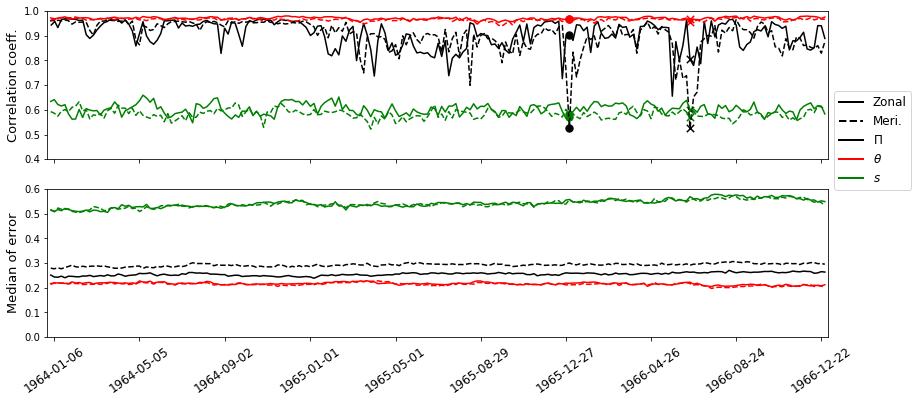

In [22]:
timeaxis = np.concatenate((np.concatenate((
                           np.arange('1964-01-01','1964-12-31',np.timedelta64(5,'D'), 
                                     dtype='datetime64[D]'),
                           np.arange('1965-01-01','1965-12-31',np.timedelta64(5,'D'), 
                                     dtype='datetime64[D]'))),
                           np.arange('1966-01-01','1966-12-31',np.timedelta64(5,'D'), 
                                     dtype='datetime64[D]')))
custom_lines = [Line2D([0], [0], color='k', lw=2, ls='-'),
                Line2D([0], [0], color='k', lw=2, ls='--'),
                Line2D([0], [0], color='k', lw=2),
                Line2D([0], [0], color='r', lw=2),
                Line2D([0], [0], color='g', lw=2)]
ssize = 54

fig, (ax1,ax2) = plt.subplots(figsize=(14,6), nrows=2, ncols=1)
# fig.set_tight_layout(True)

ax1.plot(timeaxis, dsr.rxP.isel(sig=3), 'k', label=r"$\Pi$ (zonal)")
ax1.plot(timeaxis, dsr.ryP.isel(sig=3), 'k--', label=r"$\Pi$ (meri)")
ax1.plot(timeaxis, dsr.rxT.isel(sig=3), 'r', label=r"$\theta$ (zonal)")
ax1.plot(timeaxis, dsr.ryT.isel(sig=3), 'r--', label=r"$\theta$ (meri)")
ax1.plot(timeaxis, dsr.rxS.isel(sig=3), 'g', label=r"$s$ (zonal)")
ax1.plot(timeaxis, dsr.ryS.isel(sig=3), 'g--', label=r"$s$ (meri)")
ax1.scatter(timeaxis[146], dsr.rxP.isel(sig=3,time=146), marker='o', c='k', s=ssize)
ax1.scatter(timeaxis[146], dsr.ryP.isel(sig=3,time=146), marker='o', c='k', s=ssize)
ax1.scatter(timeaxis[146], dsr.rxT.isel(sig=3,time=146), marker='o', c='r', s=ssize)
ax1.scatter(timeaxis[146], dsr.ryT.isel(sig=3,time=146), marker='o', c='r', s=ssize)
ax1.scatter(timeaxis[146], dsr.rxS.isel(sig=3,time=146), marker='o', c='g', s=ssize)
ax1.scatter(timeaxis[146], dsr.ryS.isel(sig=3,time=146), marker='o', c='g', s=ssize)
ax1.scatter(timeaxis[180], dsr.rxP.isel(sig=3,time=180), marker='x', c='k', s=ssize)
ax1.scatter(timeaxis[180], dsr.ryP.isel(sig=3,time=180), marker='x', c='k', s=ssize)
ax1.scatter(timeaxis[180], dsr.rxT.isel(sig=3,time=180), marker='x', c='r', s=ssize)
ax1.scatter(timeaxis[180], dsr.ryT.isel(sig=3,time=180), marker='x', c='r', s=ssize)
ax1.scatter(timeaxis[180], dsr.rxS.isel(sig=3,time=180), marker='x', c='g', s=ssize)
ax1.scatter(timeaxis[180], dsr.ryS.isel(sig=3,time=180), marker='x', c='g', s=ssize)


ax2.plot(timeaxis, np.nanmedian(dse.exP.isel(sig=3),axis=(1,2)), 'k', label=r"$r^u_\Pi$")
ax2.plot(timeaxis, np.nanmedian(dse.eyP.isel(sig=3),axis=(1,2)), 'k--', label=r"$r^v_\Pi$")
ax2.plot(timeaxis, np.nanmedian(dse.exT.isel(sig=3),axis=(1,2)), 'r', label=r"$r^u_\theta$")
ax2.plot(timeaxis, np.nanmedian(dse.eyT.isel(sig=3),axis=(1,2)), 'r--', label=r"$r^v_\theta$")
ax2.plot(timeaxis, np.nanmedian(dse.exS.isel(sig=3),axis=(1,2)), 'g', label=r"$r^u_s$")
ax2.plot(timeaxis, np.nanmedian(dse.eyS.isel(sig=3),axis=(1,2)), 'g--', label=r"$r^v_s$")


ax1.legend(custom_lines, ['Zonal', 'Meri.', r"$\Pi$", r"$\theta$", r"$s$"], 
           bbox_to_anchor=(1,.5), fontsize=12)

ax1.set_xlim([timeaxis[0]-np.timedelta64(5,'D'),timeaxis[-1]+np.timedelta64(5,'D')])
ax2.set_xlim([timeaxis[0]-np.timedelta64(5,'D'),timeaxis[-1]+np.timedelta64(5,'D')])
ax1.set_xticks(timeaxis[1::24])
ax1.set_xticklabels([])
ax2.set_xticks(timeaxis[1::24])
ax2.set_xticklabels(timeaxis[1::24], rotation=35, fontsize=12)
ax1.set_ylim([.4,1.])
ax2.set_ylim([0.,.6])
ax1.set_ylabel(r"Correlation coeff.", fontsize=13)
ax2.set_ylabel(r"Median of error", fontsize=13)
plt.savefig(op.join(ddir,'Figures/CorrCoef-error_isig17_Hann_no-smoothness.pdf'))

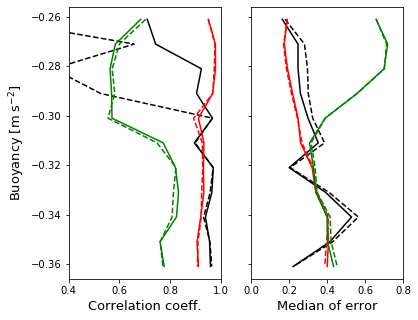

In [21]:
buoyb = -grav*rxP.sig*rhoConst**-1
ntime = 146
fig, (ax1,ax2) = plt.subplots(figsize=(6,5), nrows=1, ncols=2)
# fig.set_tight_layout(True)

ax1.plot(dsr.rxP.isel(time=ntime), buoyb, 'k', label=r"$\Pi$ (zonal)")
ax1.plot(dsr.ryP.isel(time=ntime), buoyb, 'k--', label=r"$\Pi$ (meri)")
ax1.plot(dsr.rxT.isel(time=ntime), buoyb, 'r', label=r"$\theta$ (zonal)")
ax1.plot(dsr.ryT.isel(time=ntime), buoyb, 'r--', label=r"$\theta$ (meri)")
ax1.plot(dsr.rxS.isel(time=ntime), buoyb, 'g', label=r"$s$ (zonal)")
ax1.plot(dsr.ryS.isel(time=ntime), buoyb, 'g--', label=r"$s$ (meri)")

ax2.plot(np.nanmedian(dse.exP.isel(time=ntime),axis=(0,1)), buoyb, 
         'k', label=r"$r^u_\Pi$")
ax2.plot(np.nanmedian(dse.eyP.isel(time=ntime),axis=(0,1)), buoyb, 
         'k--', label=r"$r^v_\Pi$")
ax2.plot(np.nanmedian(dse.exT.isel(time=ntime),axis=(0,1)), buoyb, 
         'r', label=r"$r^u_\theta$")
ax2.plot(np.nanmedian(dse.eyT.isel(time=ntime),axis=(0,1)), buoyb, 
         'r--', label=r"$r^v_\theta$")
ax2.plot(np.nanmedian(dse.exS.isel(time=ntime),axis=(0,1)), buoyb, 
         'g', label=r"$r^u_s$")
ax2.plot(np.nanmedian(dse.eyS.isel(time=ntime),axis=(0,1)), buoyb, 
         'g--', label=r"$r^v_s$")

# ax1.legend(fontsize=12, loc='lower left')
ax1.set_xlim([.4,1.])
ax2.set_xlim([0.,.8])
ax1.set_yticks([-.36,-.34,-.32,-.30,-.28,-.26])
ax2.set_yticks([-.36,-.34,-.32,-.30,-.28,-.26])
ax2.set_yticklabels([])
ax1.set_xlabel(r"Correlation coeff.", fontsize=13)
ax2.set_xlabel(r"Median of error", fontsize=13)
ax1.set_ylabel(r"Buoyancy [m s$^{-2}$]", fontsize=13)
plt.savefig(op.join(ddir,'Figures/CorrCoef-error_1966-01-01_Hann_no-smoothness.pdf'))

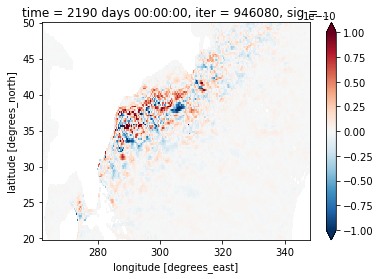

In [30]:
upPp.isel(sig=3).plot(vmax=1e-10)

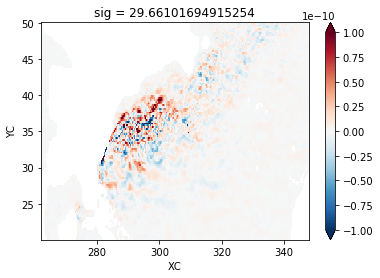

In [16]:
FxP.isel(sig=3).plot(vmax=1e-10)

In [10]:
timeaxis

array(['1964-01-01', '1964-01-06', '1964-01-11', '1964-01-16',
       '1964-01-21', '1964-01-26', '1964-01-31', '1964-02-05',
       '1964-02-10', '1964-02-15', '1964-02-20', '1964-02-25',
       '1964-03-01', '1964-03-06', '1964-03-11', '1964-03-16',
       '1964-03-21', '1964-03-26', '1964-03-31', '1964-04-05',
       '1964-04-10', '1964-04-15', '1964-04-20', '1964-04-25',
       '1964-04-30', '1964-05-05', '1964-05-10', '1964-05-15',
       '1964-05-20', '1964-05-25', '1964-05-30', '1964-06-04',
       '1964-06-09', '1964-06-14', '1964-06-19', '1964-06-24',
       '1964-06-29', '1964-07-04', '1964-07-09', '1964-07-14',
       '1964-07-19', '1964-07-24', '1964-07-29', '1964-08-03',
       '1964-08-08', '1964-08-13', '1964-08-18', '1964-08-23',
       '1964-08-28', '1964-09-02', '1964-09-07', '1964-09-12',
       '1964-09-17', '1964-09-22', '1964-09-27', '1964-10-02',
       '1964-10-07', '1964-10-12', '1964-10-17', '1964-10-22',
       '1964-10-27', '1964-11-01', '1964-11-06', '1964-

In [20]:
timeaxis[146]

numpy.datetime64('1966-01-01')